### Importing Necessary Libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.regularizers import l2

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing & Opening the data 

In [3]:
# Load the dataset
netcdf_file_path = "Data/final_SSC_Data.nc"

# Open the data using xarray
dataset = xr.open_dataset(netcdf_file_path)

### Converting Dataframe to Pandas and Dropping uneccessary Columns

In [4]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

df

,time,lat,lon,u,v
0,2020-02-25 15:00:00,35.744701,13.6768,NaN,NaN
1,2020-02-25 15:00:00,35.744701,13.7174,NaN,NaN
2,2020-02-25 15:00:00,35.744701,13.7579,NaN,NaN
3,2020-02-25 15:00:00,35.744701,13.7985,NaN,NaN
4,2020-02-25 15:00:00,35.744701,13.8390,NaN,NaN
...,...,...,...,...,...
60892983,2023-08-01 23:00:00,36.880199,15.2182,NaN,NaN
60892984,2023-08-01 23:00:00,36.880199,15.2587,NaN,NaN
60892985,2023-08-01 23:00:00,36.880199,15.2993,NaN,NaN
60892986,2023-08-01 23:00:00,36.880199,15.3398,NaN,NaN


### Filtering Dataframe by specific pair of coordinates & applying Spline Interpolation to NaNs

In [5]:
# Define target latitude and longitude for data filtering.
target_lat = 36.03409957885742
target_lon = 14.528599739074707

# Filter the DataFrame to only include data for the specified coordinates.
df = df[(df['lat'] == target_lat) & (df['lon'] == target_lon)]

# Ensure the DataFrame is sorted by time
df.sort_index(inplace=True)

# Drop rows where either 'u' or 'v' (or both) have NaN values
df.dropna(subset=['u', 'v'], inplace=True)

df

C:\Users\MarkDingli\AppData\Local\Temp\ipykernel_11552\1160317032.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['u', 'v'], inplace=True)


,time,lat,lon,u,v
580,2020-02-25 15:00:00,36.0341,14.5286,0.142856,-0.085644
2816,2020-02-25 16:00:00,36.0341,14.5286,0.133010,-0.018187
5052,2020-02-25 17:00:00,36.0341,14.5286,0.096112,0.009815
7288,2020-02-25 18:00:00,36.0341,14.5286,0.075022,0.004789
9524,2020-02-25 19:00:00,36.0341,14.5286,0.039128,0.012974
...,...,...,...,...,...
60882388,2023-08-01 19:00:00,36.0341,14.5286,0.140230,-0.185754
60884624,2023-08-01 20:00:00,36.0341,14.5286,0.113880,-0.225836
60886860,2023-08-01 21:00:00,36.0341,14.5286,0.101888,-0.212993
60889096,2023-08-01 22:00:00,36.0341,14.5286,0.108439,-0.201915


### Converting the 'time' column to datetime format & setting it as the index

In [6]:
df[['time', 'u', 'v']]

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

# Set the 'time' column as the index of the DataFrame
df.set_index('time')['u']

C:\Users\MarkDingli\AppData\Local\Temp\ipykernel_11552\1220816150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


time
2020-02-25 15:00:00    0.142856
2020-02-25 16:00:00    0.133010
2020-02-25 17:00:00    0.096112
2020-02-25 18:00:00    0.075022
2020-02-25 19:00:00    0.039128
                         ...   
2023-08-01 19:00:00    0.140230
2023-08-01 20:00:00    0.113880
2023-08-01 21:00:00    0.101888
2023-08-01 22:00:00    0.108439
2023-08-01 23:00:00    0.182186
Name: u, Length: 14282, dtype: float64

### Plotting the 'u' and 'v' 

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

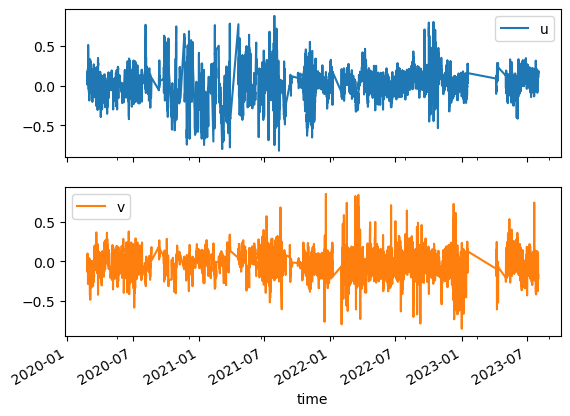

In [7]:
# Plot 'u' and 'v' columns over time
df.set_index('time')[['u', 'v']].plot(subplots=True)

### Preparing the input features

In [8]:
# Select 'u' and 'v' columns as input features
df_input = df[['u', 'v']]
df_input

,u,v
580,0.142856,-0.085644
2816,0.133010,-0.018187
5052,0.096112,0.009815
7288,0.075022,0.004789
9524,0.039128,0.012974
...,...,...
60882388,0.140230,-0.185754
60884624,0.113880,-0.225836
60886860,0.101888,-0.212993
60889096,0.108439,-0.201915


### Saving as features & setting the targets

In [9]:
# Save data as features for model input
features = df_input.to_numpy()

# Set the first column as the target variable
target = df_input['u'].values   

### Splitting Data in Train & Test splits

In [10]:
# First, split into training (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)

# Then, split the temp set into validation and test sets (50% each of 30% => 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, shuffle=False)

# Check the shape of each set
X_train.shape, X_val.shape, X_test.shape

((9997, 2), (2142, 2), (2143, 2))

### Creating batches of time series data 

In [11]:
win_length = 72 # 3 days
batch_size = 64
num_features = 2

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[ 1.42855685e-01, -8.56435634e-02],
         [ 1.33010397e-01, -1.81869788e-02],
         [ 9.61117697e-02,  9.81482686e-03],
         ...,
         [-8.95843009e-02, -1.16424937e-01],
         [-5.93716567e-02, -5.80345871e-02],
         [-4.24875665e-02, -5.03646718e-02]],
 
        [[ 1.33010397e-01, -1.81869788e-02],
         [ 9.61117697e-02,  9.81482686e-03],
         [ 7.50224016e-02,  4.78938435e-03],
         ...,
         [-5.93716567e-02, -5.80345871e-02],
         [-4.24875665e-02, -5.03646718e-02],
         [-1.81419495e-02, -5.56737994e-02]],
 
        [[ 9.61117697e-02,  9.81482686e-03],
         [ 7.50224016e-02,  4.78938435e-03],
         [ 3.91283655e-02,  1.29743425e-02],
         ...,
         [-4.24875665e-02, -5.03646718e-02],
         [-1.81419495e-02, -5.56737994e-02],
         [ 1.58197623e-03, -2.44239313e-02]],
 
        ...,
 
        [[-7.80175041e-03, -3.14467887e-02],
         [ 3.16120583e-02, -6.65767914e-02],
         [ 3.21828482e-02, -1.2196

### Constructing the LSTM Model

In [12]:
model = Sequential([ 
    LSTM(256, input_shape=(win_length, num_features), return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 256)           265216    
                                                                 
 dropout (Dropout)           (None, 72, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 72, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 72, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

### Training the Model

In [13]:
# Set up early stopping 
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               mode='min',
                               restore_best_weights=True)

# Compile the model 
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.001),
              metrics=[MeanAbsoluteError()])

# Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_test_model",
                                   save_best_only=True,
                                   monitor='val_loss',  
                                   mode='min',
                                   verbose=0)  

# Fit the model to
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    shuffle=False,
                    callbacks=[early_stopping, model_checkpoint])

# Determine the epoch number at best performance
best_epoch = early_stopping.stopped_epoch - early_stopping.patience

print(f"="*125)
print(f"Training stopped at epoch: {best_epoch + 1}")
print(f"Best validation loss achieved at epoch: {best_epoch + 1}")

Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.0195 - mean_absolute_error: 0.0973INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


156/156 [==============================] - 121s 745ms/step - loss: 0.0195 - mean_absolute_error: 0.0973 - val_loss: 0.0106 - val_mean_absolute_error: 0.0685
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0779INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


156/156 [==============================] - 94s 603ms/step - loss: 0.0138 - mean_absolute_error: 0.0779 - val_loss: 0.0082 - val_mean_absolute_error: 0.0563
Epoch 3/100
156/156 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0658INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


156/156 [==============================] - 94s 601ms/step - loss: 0.0108 - mean_absolute_error: 0.0658 - val_loss: 0.0070 - val_mean_absolute_error: 0.0476
Epoch 4/100
156/156 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0601INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


156/156 [==============================] - 108s 690ms/step - loss: 0.0097 - mean_absolute_error: 0.0601 - val_loss: 0.0066 - val_mean_absolute_error: 0.0445
Epoch 5/100
156/156 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0588INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


156/156 [==============================] - 147s 944ms/step - loss: 0.0095 - mean_absolute_error: 0.0588 - val_loss: 0.0065 - val_mean_absolute_error: 0.0443
Epoch 6/100
156/156 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0583INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


156/156 [==============================] - 117s 752ms/step - loss: 0.0094 - mean_absolute_error: 0.0583 - val_loss: 0.0065 - val_mean_absolute_error: 0.0440
Epoch 7/100
156/156 [==============================] - 120s 770ms/step - loss: 0.0095 - mean_absolute_error: 0.0587 - val_loss: 0.0066 - val_mean_absolute_error: 0.0446
Epoch 8/100
156/156 [==============================] - 203s 1s/step - loss: 0.0094 - mean_absolute_error: 0.0587 - val_loss: 0.0066 - val_mean_absolute_error: 0.0454
Epoch 9/100
156/156 [==============================] - 209s 1s/step - loss: 0.0094 - mean_absolute_error: 0.0588 - val_loss: 0.0066 - val_mean_absolute_error: 0.0448
Training stopped at epoch: 6
Best validation loss achieved at epoch: 6


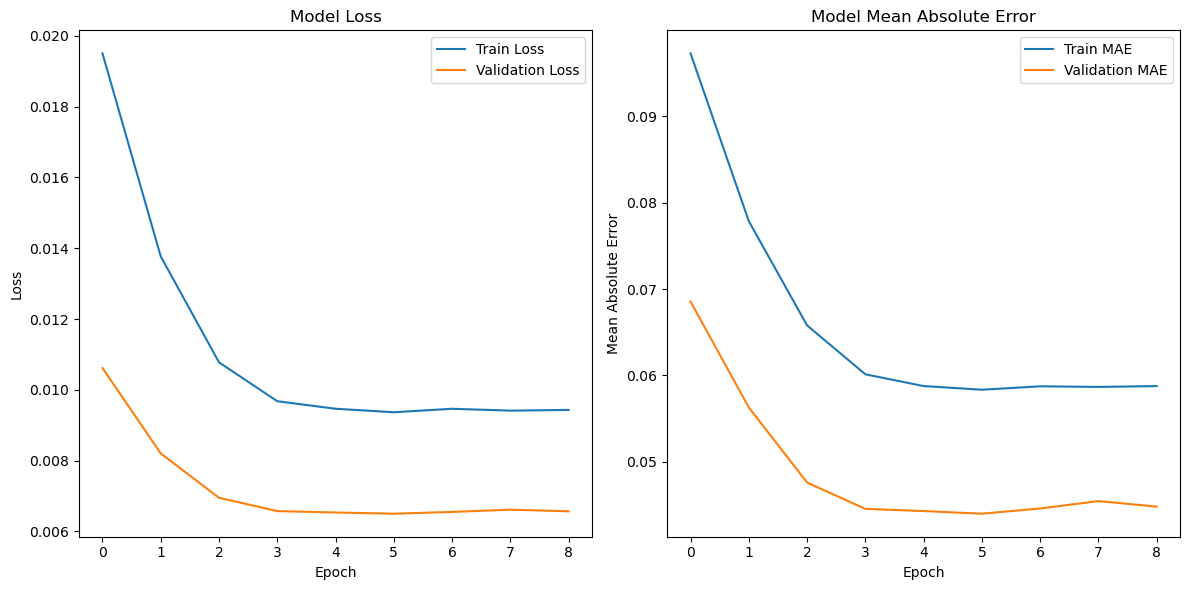

In [14]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Making predictions & evaluating from the Test set

In [15]:
# Generate predictions for the test data
predictions = model.predict(test_generator)

33/33 [==============================] - 9s 257ms/step


### Preparing the final DataFrame for plotting and analysis

In [16]:
df_final = df_input.iloc[-len(predictions):].copy()

df_final['u_pred'] = predictions.flatten()

df_final

,u,v,u_pred
56068280,-0.005565,-0.118616,-0.014723
56070516,0.016014,-0.022374,-0.001103
56072752,0.052322,-0.015469,0.019626
56074988,0.069166,-0.041614,0.051641
56077224,0.114014,-0.040209,0.070883
...,...,...,...
60882388,0.140230,-0.185754,0.124188
60884624,0.113880,-0.225836,0.120368
60886860,0.101888,-0.212993,0.101406
60889096,0.108439,-0.201915,0.088070


In [17]:
# Actual and predicted 'u' values
y_true = df_final['u'].values
y_pred = df_final['u_pred'].values

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Print out the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 0.0020417651175904227
Mean Absolute Error (MAE): 0.0334470081322434
Root Mean Squared Error (RMSE): 0.04518589511772919


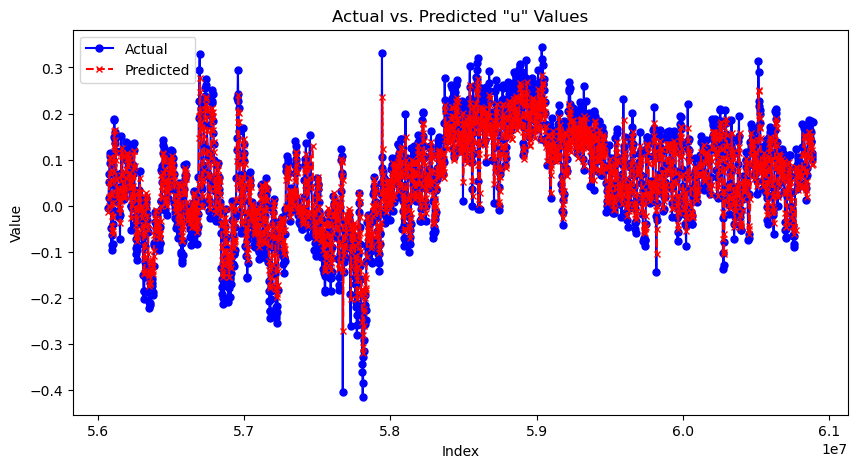

In [18]:
plt.figure(figsize=(10, 5))  
plt.plot(df_final.index, df_final['u'], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(df_final.index, df_final['u_pred'], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
plt.title('Actual vs. Predicted "u" Values')  
plt.xlabel('Index') 
plt.ylabel('Value')  
plt.legend() 
plt.show() 

### Making a real life Rolling Prediction

In [19]:
# Number of hours to predict into the future
n_future_hours = 24

# Path to the NetCDF file containing input data from August 1, 2023 till august 3, 2023
input_data_path = "Data/3_day_input_SSC_Data.nc"

# Load the dataset
input_dataset = xr.open_dataset(input_data_path)

# Select data for the target latitude and longitude
input_data = input_dataset.sel(lat=target_lat, lon=target_lon, method='nearest').to_dataframe().reset_index()

# Ensure the DataFrame is sorted by time (if not already)
input_data.sort_values('time', inplace=True)

# Interpolate NaN values using cubic spline interpolation
input_data[['u', 'v']] = input_data[['u', 'v']].interpolate(method='spline', order=3)

# After interpolation, if there are still NaNs at the beginning or the end, fill them with the first/last valid value
input_data[['u', 'v']] = input_data[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

# Select and preprocess the required features
features = input_data[['u', 'v']].values

# Check if the number of samples is less than the desired window length
if len(features) < win_length:
    raise ValueError("Not enough samples in the input data to match the desired window length.")

# Reshape data to match the input shape expected by the LSTM model
last_24_hours_features = features[-win_length:].reshape(1, win_length, num_features)

# Initialize the array to store predictions
predictions_u = []

# Make predictions for each hour
for i in range(n_future_hours):
    # Predict the next step
    current_prediction_u = model.predict(last_24_hours_features, verbose=0)[0, 0]
    
    # Append the prediction to the predictions list
    predictions_u.append(current_prediction_u)
    
    # Update the last 24 hours for the next prediction, incorporating actual 'v' values
    # Extract the next set of 'v' values from the input features, ensuring continuity
    next_v_values = features[i + 1:min(i + win_length, len(features)), 1] if i + 1 < len(features) else features[-win_length:, 1]
    
    # Update 'u' with the current prediction and 'v' with the next set of actual values
    updated_features = np.column_stack((
        np.append(last_24_hours_features[0, 1:, 0], current_prediction_u),  # Update 'u' values
        np.append(next_v_values, np.full((win_length - len(next_v_values),), next_v_values[-1]))  # Update 'v' values, fill if necessary
    ))
    
    # Reshape for the next prediction
    last_24_hours_features = updated_features.reshape(1, win_length, num_features)

In [20]:
# Load the actual data equivalent to the next day (August 4th, 2023)
actual_data_nc = xr.open_dataset('Data/1_day_actual_4th_SSC_Data.nc')

# Convert to DataFrame and filter based on selected latitude and longitude
actual_data_df = actual_data_nc.sel(lat=target_lat, lon=target_lon, method='nearest').to_dataframe().reset_index()

# Ensure the DataFrame is sorted by time
actual_data_df.sort_values('time', inplace=True) 

# Clean up the DataFrame by dropping unnecessary columns
actual_data_df = actual_data_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Remove NaN values from the DataFrame
actual_data_df.dropna(inplace=True)

# Extract 'u' values from the actual data
actual_u_values = actual_data_df['u'].values

# Ensure that the actual data and predictions have the same length
trimmed_predictions_u = predictions_u[:len(actual_u_values)]

# Calculate evaluation metrics using the trimmed predictions
mae = mean_absolute_error(actual_u_values, trimmed_predictions_u)
mse = mean_squared_error(actual_u_values, trimmed_predictions_u)
rmse = np.sqrt(mse)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Create a DataFrame to store actual and predicted values for comparison
comparison_df = pd.DataFrame({
    'Time': actual_data_df['time'],
    'Actual_u': actual_u_values,
    'Predicted_u': trimmed_predictions_u
})

# Display the DataFrame for review
comparison_df

Mean Absolute Error (MAE): 0.05481911102839559
Mean Squared Error (MSE): 0.003961051236525733
Root Mean Squared Error (RMSE): 0.06293688295845079


,Time,Actual_u,Predicted_u
0,2023-08-04 00:00:00,0.014670,-0.014008
1,2023-08-04 01:00:00,0.044976,0.004366
2,2023-08-04 02:00:00,0.068408,0.019206
3,2023-08-04 03:00:00,0.076035,0.030530
4,2023-08-04 04:00:00,0.088732,0.038689
5,2023-08-04 05:00:00,0.051816,0.044200
6,2023-08-04 06:00:00,0.085878,0.047619
9,2023-08-04 09:00:00,0.089445,0.049457
10,2023-08-04 10:00:00,0.095997,0.050149
11,2023-08-04 11:00:00,0.072807,0.050060
